<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/3. PINN_inverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

Governing equation:
$$
dx/dt = \sigma(y-x)
$$
$$
dy/dt = x( \rho -z)-y
$$
$$
dz/dt = xy-\beta z
$$

Initial condition:
$$
x(0)=-8,  \quad y(0)=7,  \quad z(0)=27
$$

In [ ]:
!wget https://github.com/sjoon0305/KSME2026/raw/main/a.Lorenz.npz

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# 1. 환경 설정 및 장치 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. 신경망 정의 (Lorenz의 x, y, z 세 상태 변수 출력)
class LorenzNet(nn.Module):
    def __init__(self):
        super(LorenzNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 3) # 출력은 x, y, z
        )

    def forward(self, t):
        return self.net(t)

# 3. 모델 및 학습 파라미터(Inverse Variables) 초기화
model = LorenzNet().to(device)

# 찾고자 하는 미지의 상수 (초기값 1.0으로 설정)
C1 = torch.nn.Parameter(torch.tensor([1.0], device=device, requires_grad=True))
C2 = torch.nn.Parameter(torch.tensor([1.0], device=device, requires_grad=True))
C3 = torch.nn.Parameter(torch.tensor([1.0], device=device, requires_grad=True))
external_trainable_variables = [C1, C2, C3]

# 최적화 도구: 신경망 가중치와 미지의 상수를 동시에 학습
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': external_trainable_variables}
    ], lr = 0.001)


# 4. 손실 함수 정의
def get_losses(t_collo, t_obs, obs_data, t_ic, xyz_ic):
    # (A) Physics (ODE) Loss
    t_collo.requires_grad_(True)
    out = model(t_collo)
    x, y, z = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    # 각 변수의 시간 미분 계산
    dx_t = torch.autograd.grad(x, t_collo, torch.ones_like(x), create_graph=True)[0]
    dy_t = torch.autograd.grad(y, t_collo, torch.ones_like(y), create_graph=True)[0]
    dz_t = torch.autograd.grad(z, t_collo, torch.ones_like(z), create_graph=True)[0]

    # 로렌츠 방정식 잔차 계산
    f1 = dx_t - C1 * (y - x)
    f2 = dy_t - (x * (C2 - z) - y)
    f3 = dz_t - (x * y - C3 * z)
    loss_pde = torch.mean(f1**2 + f2**2 + f3**2)

    # (B) Observation Data Loss
    out_obs = model(t_obs)
    loss_obs = torch.mean((out_obs - obs_data)**2)

    # (C) Initial Condition Loss (t=0)
    out_ic = model(t_ic)
    loss_ic = torch.mean((out_ic - xyz_ic)**2)

    return loss_pde, loss_obs, loss_ic


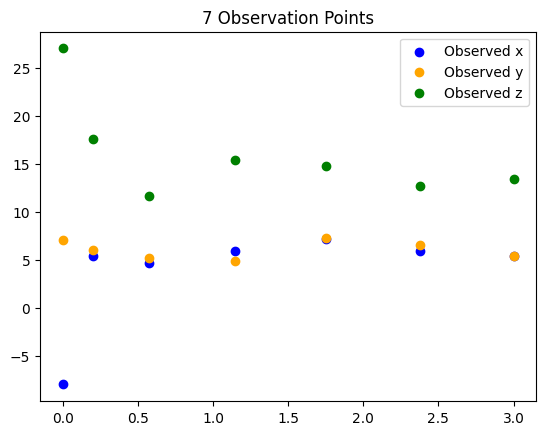

In [3]:
def gen_traindata():
    data = np.load("./a.Lorenz_sparse.npz")
    return data["t"], data["y"]

observe_t, ob_u = gen_traindata()
observe_x = ob_u[:,0:1]
observe_y = ob_u[:,1:2]
observe_z = ob_u[:,2:3]

pt_observe_t = Variable(torch.from_numpy(observe_t).float(), requires_grad=False).to(device)
pt_observe_x = Variable(torch.from_numpy(observe_x).float(), requires_grad=False).to(device)
pt_observe_y = Variable(torch.from_numpy(observe_y).float(), requires_grad=False).to(device)
pt_observe_z = Variable(torch.from_numpy(observe_z).float(), requires_grad=False).to(device)

import matplotlib.pyplot as plt

plt.scatter(observe_t, observe_x, label='Observed x', color='blue')
plt.scatter(observe_t, observe_y, label='Observed y', color='orange')
plt.scatter(observe_t, observe_z, label='Observed z', color='green')

plt.title('7 Observation Points')
plt.legend()
plt.show()

In [4]:
# 5. 학습 루프
iterations = 30000
history = {'loss': [], 'C1': [], 'C2': [], 'C3': []}

# 가상의 관측 데이터 (실제 데이터가 있다면 여기 대입)
# 예시: t_obs_np, x_obs_np, y_obs_np, z_obs_np 준비됨을 가정
t_obs_torch = torch.from_numpy(observe_t).float().to(device)
obs_data_torch = torch.cat([pt_observe_x, pt_observe_y, pt_observe_z], dim=1).to(device)
t_ic_torch = torch.tensor([[0.0]], device=device)
ic_value = torch.tensor([[-8.0, 7.0, 27.0]], device=device)

for epoch in range(iterations):
    # Collocation points (물리 법칙을 확인할 무작위 지점들)
    t_collo = torch.rand(500, 1, device=device) * 3.0 
    
    loss_pde, loss_obs, loss_ic = get_losses(t_collo, t_obs_torch, obs_data_torch, t_ic_torch, ic_value)
    total_loss = loss_pde + 3*loss_obs + loss_ic

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # 기록 보관
    history['C1'].append(C1.item())
    history['C2'].append(C2.item())
    history['C3'].append(C3.item())
    history['loss'].append(total_loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Loss: {total_loss.item():.5f} | C1: {C1.item():.3f}, C2: {C2.item():.3f}, C3: {C3.item():.3f}")

Epoch     0 | Loss: 635.52051 | C1: 0.999, C2: 0.999, C3: 0.999
Epoch  1000 | Loss: 70.78822 | C1: 0.182, C2: 1.343, C3: 0.243
Epoch  2000 | Loss: 68.60955 | C1: 0.210, C2: 2.100, C3: 0.151
Epoch  3000 | Loss: 65.64162 | C1: 0.255, C2: 3.172, C3: 0.136
Epoch  4000 | Loss: 64.63123 | C1: 0.284, C2: 4.274, C3: 0.118
Epoch  5000 | Loss: 65.35698 | C1: 0.308, C2: 5.363, C3: 0.106
Epoch  6000 | Loss: 63.84855 | C1: 0.333, C2: 6.438, C3: 0.097
Epoch  7000 | Loss: 62.96053 | C1: 0.366, C2: 7.518, C3: 0.096
Epoch  8000 | Loss: 61.08192 | C1: 0.412, C2: 8.650, C3: 0.112
Epoch  9000 | Loss: 39.42484 | C1: 1.005, C2: 10.383, C3: 1.071
Epoch 10000 | Loss: 20.37030 | C1: 2.205, C2: 11.686, C3: 1.981
Epoch 11000 | Loss: 12.45075 | C1: 3.170, C2: 12.548, C3: 2.360
Epoch 12000 | Loss: 8.08321 | C1: 4.001, C2: 13.245, C3: 2.503
Epoch 13000 | Loss: 5.41507 | C1: 4.784, C2: 13.819, C3: 2.550
Epoch 14000 | Loss: 3.55637 | C1: 5.537, C2: 14.250, C3: 2.576
Epoch 15000 | Loss: 2.34062 | C1: 6.270, C2: 14.524

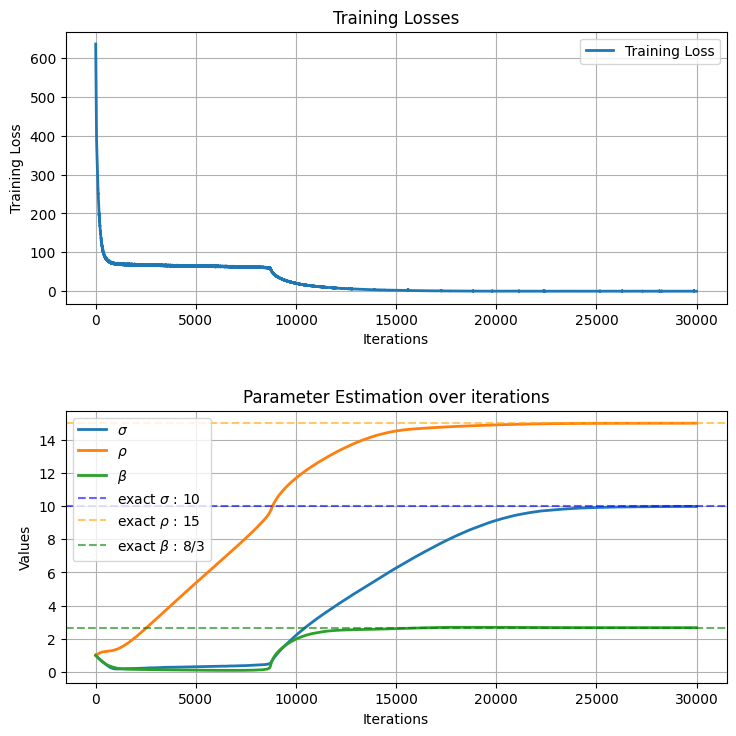

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# 세로 배치를 위해 figsize 조정 (가로 10, 세로 8)
plt.figure(figsize=(8, 8))
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

# 첫 번째 플롯 (위쪽)
ax2 = plt.subplot(gs1[0])
ax2.plot(range(iterations), history['loss'], label='Training Loss', linewidth=2)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Training Loss')
ax2.set_title('Training Losses')
ax2.legend()
ax2.grid(True)

# 두 번째 플롯 (아래쪽)
ax1 = plt.subplot(gs1[1])
# LaTeX 형식 적용 및 선 굵기(linewidth)도 살짝 조절
ax1.plot(range(iterations), history['C1'], label='$\\sigma$', linewidth=2)
ax1.plot(range(iterations), history['C2'], label='$\\rho$', linewidth=2)
ax1.plot(range(iterations), history['C3'], label='$\\beta$', linewidth=2)

ax1.axhline(y=10, linestyle='--', color='blue', alpha=0.6, label='exact $\\sigma$ : 10')
ax1.axhline(y=15, linestyle='--', color='orange', alpha=0.6, label='exact $\\rho$ : 15')
ax1.axhline(y=8/3, linestyle='--', color='green', alpha=0.6, label='exact $\\beta$ : $8/3$')

ax1.set_xlabel('Iterations')
ax1.set_ylabel('Values')
ax1.set_title('Parameter Estimation over iterations')
ax1.legend()
# ax1.legend(loc='upper right') # 범례 위치 조정
ax1.grid(True)

plt.tight_layout(pad=3.0) # 요소 간 간격 확보
plt.savefig('training_result_large_font.png')

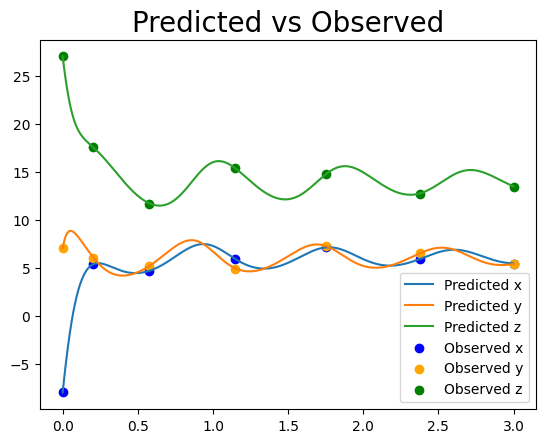

In [6]:
import matplotlib.pyplot as plt
t = np.arange(0, 3, 0.001)
t = np.ravel(t).reshape(-1, 1)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
out = model(pt_t)
pt_x,pt_y,pt_z = out[:, 0:1], out[:, 1:2], out[:, 2:3]
x = pt_x.data.cpu().numpy()
x = x.reshape(t.shape)

y = pt_y.data.cpu().numpy()
y = y.reshape(t.shape)

z = pt_z.data.cpu().numpy()
z = z.reshape(t.shape)

plt.plot(t,x, label='Predicted x')
plt.plot(t,y, label='Predicted y')
plt.plot(t,z, label='Predicted z')


plt.scatter(observe_t, observe_x, label='Observed x', color='blue')
plt.scatter(observe_t, observe_y, label='Observed y', color='orange')
plt.scatter(observe_t, observe_z, label='Observed z', color='green')
plt.title('Predicted vs Observed', fontsize=20)
plt.legend()
plt.show()

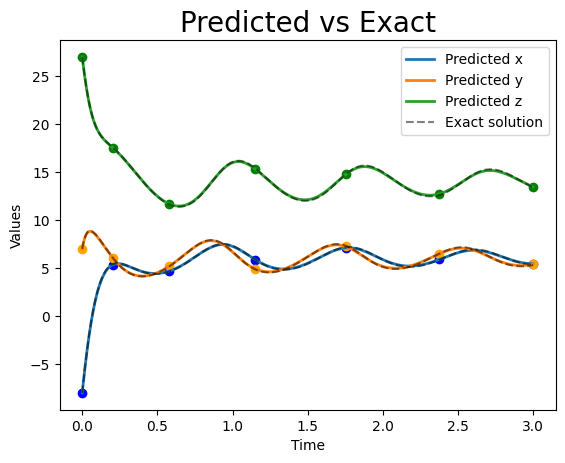

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def Lorenz(xyz, *, s=10, r=15, b=8/3):  # 15,28
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.001
num_steps = 3000

xyzs = np.empty((num_steps + 1, 3))
xyzs[0] = (-8., 7., 27.)   # 기존: xyzs[0] = (0., 1., 1.05),(-8., 7., 27.)
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + Lorenz(xyzs[i]) * dt

import matplotlib.pyplot as plt
t = np.arange(0, 3, 0.001)
t = np.ravel(t).reshape(-1, 1)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
out = model(pt_t)
pt_x,pt_y,pt_z = out[:, 0:1], out[:, 1:2], out[:, 2:3]
x = pt_x.data.cpu().numpy()
x = x.reshape(t.shape)

y = pt_y.data.cpu().numpy()
y = y.reshape(t.shape)

z = pt_z.data.cpu().numpy()
z = z.reshape(t.shape)

plt.plot(t,x, label='Predicted x', linewidth=2)
plt.plot(t,y, label='Predicted y', linewidth=2)
plt.plot(t,z, label='Predicted z', linewidth=2)


plt.scatter(observe_t, observe_x, color='blue')
plt.scatter(observe_t, observe_y, color='orange')
plt.scatter(observe_t, observe_z, color='green')

plt.plot(np.linspace(0, 3, 3001), xyzs[:, 0], c='black', linestyle='--', label='Exact solution', alpha=0.5, linewidth=1.5)
plt.plot(np.linspace(0, 3, 3001), xyzs[:, 1], c='black', linestyle='--', alpha=0.5, linewidth=1.5)
plt.plot(np.linspace(0, 3, 3001), xyzs[:, 2], c='black', linestyle='--', alpha=0.5, linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs Exact', fontsize=20)
plt.legend()
plt.show()